In [1]:
%pip install pandas matplotlib pillow torch numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
import numpy as np


In [3]:

# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to use CUDA GPU
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(device))
else:
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [4]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [5]:
proposal = pd.read_csv("labels_modified.txt", delimiter=" ", index_col=False)
proposal['active'] = True

In [6]:
proposal

,x_min,y_min,x_max,y_max,conf,active
0,331.860,64.771,396.510,196.329,0.238,True
1,333.997,69.336,393.069,197.359,0.856,True
2,333.275,64.350,396.262,197.069,0.245,True
3,334.161,67.613,393.245,196.415,0.401,True
4,331.211,63.680,394.060,195.494,0.241,True
...,...,...,...,...,...,...
304,58.930,360.374,131.114,488.874,0.573,True
305,63.746,357.802,130.427,487.884,0.719,True
306,60.043,361.655,131.022,489.039,0.524,True
307,59.099,361.463,132.899,489.276,0.588,True


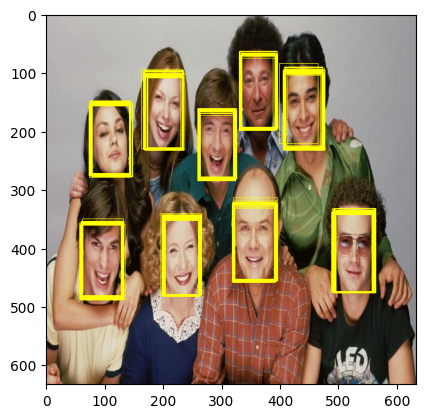

In [7]:


img = Image.open("testing.jpg",mode="r")
img = img.resize((633, 633))
for index,row in proposal.iterrows():
    x_min = float(row['x_min'])
    y_min = float(row['y_min'])
    x_max = float(row['x_max'])
    y_max = float(row['y_max'])
    conf = float(row['conf'])
    draw = ImageDraw.Draw(img)
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='yellow')


plt.imshow(img)
plt.savefig("before.jpg")




In [8]:
from copy import deepcopy
output = pd.DataFrame(columns=['x_min', 'y_min', 'x_max', 'y_max', 'conf','active'])
proposal_copy = deepcopy(proposal)
iou_threshold = 0.2
while not proposal_copy.loc[proposal_copy['active'] == True].empty:
    max_index = proposal_copy.loc[proposal_copy['active'] == True, 'conf'].idxmax()
    max_conf_proposal_copy = proposal_copy.loc[max_index]
    proposal_copy.loc[max_index, 'active'] = False
    series_df = pd.DataFrame(max_conf_proposal_copy[['x_min', 'y_min', 'x_max', 'y_max','conf' ,'active']]).T
    output = pd.concat([output, series_df])

    for i, p in proposal_copy.iterrows():
        if p['active'] == False:
            continue
        iou = bb_intersection_over_union(list(max_conf_proposal_copy[['x_min', 'y_min', 'x_max', 'y_max']]),
                                         list(p[['x_min', 'y_min', 'x_max', 'y_max']]))
        if iou > iou_threshold:
            proposal_copy.loc[i, 'active'] = False

In [9]:
output

,x_min,y_min,x_max,y_max,conf,active
203,321.095,325.102,393.671,455.93,0.994,True
126,75.717,155.071,143.927,274.019,0.993,True
251,60.789,357.51,130.725,484.878,0.988,True
248,493.231,338.057,561.106,474.959,0.981,True
72,405.573,97.715,471.964,229.785,0.98,True
232,199.357,347.287,263.968,480.068,0.976,True
44,333.132,70.125,391.635,196.208,0.968,True
147,262.967,167.86,321.573,280.322,0.967,True
82,170.711,104.013,232.063,230.407,0.96,True


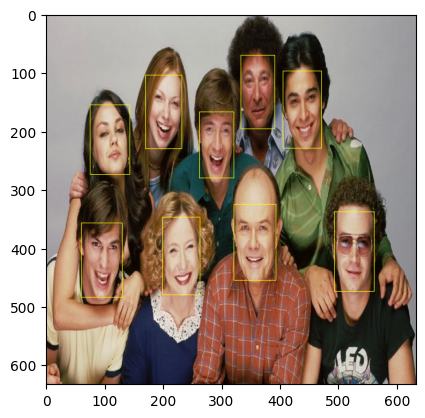

In [10]:
img = Image.open("testing.jpg",mode="r")
img = img.resize((633, 633))
for index,row in output.iterrows():
    x_min = float(row['x_min'])
    y_min = float(row['y_min'])
    x_max = float(row['x_max'])
    y_max = float(row['y_max'])
    conf = float(row['conf'])
    draw = ImageDraw.Draw(img)
    draw.rectangle([(x_min, y_min), (x_max, y_max)], outline='yellow')


plt.imshow(img)
plt.savefig("after.jpg")
